# Training WGANs on Celeba Benchmark

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn

import sys
import os
import gc
sys.path.append("..")
 
from src.plotters import PCA_plot_q_p_samples, plot_images 
from src.models import MinFunnels , Critic, Critic_sort, Tiny_Discriminator, Clipper, Spectralnorm, UNet
from src.utils import lipschitz_one_checker 
from src.map_benchmark import Cifar32Benchmark
from src.methods import train_WGAN, train_CoWGAN , train_LSOT, train_3PWGAN, train_WGAN_qp,\
                        calculate_unbiased_wasserstein, calculate_kantorovitch_wasserstein, DOT_metrics,\
                        L2_metrics, cosine_metrics
                        
                        
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
DEG, WIDTH = 100, 16 # or DEG, WIDTH = 10, 1
SEED = 295 # seed for benchmark (HARD CODED)
SEED_WGAN = 4 # seed for dual solvers
GPU_DEVICE = 1

In [4]:
torch.cuda.set_device(GPU_DEVICE)
DIM = 3*32*32

## Upload benchmark

In [5]:
benchmark = Cifar32Benchmark(width=WIDTH, deg=DEG, seed=SEED)

Benchmark pair loaded


## Hyper - parameters

In [29]:
#======= COMMON =======
NUM_SAMPLES_PLOT_PCA = 1000
BATCH_SIZE = 32
IN_CHANNELS = 3
METRIC_SIZE = 2**8
NDF = 64
 
LR = 2e-4
HIDDEN_DIMS  = [DIM, 2000, 1000, 128, 1] 

#======== WGAN =========
BOUND =  0.04
NUM_ITERATIONS_WGAN = 5000

#======= WGAN-GP ======
LAMBDA_GP = 10.
NUM_ITERATIONS_WGAN_GP = 30000

#======= WGAN-LP ======
LAMBDA_LP = 10.
NUM_ITERATIONS_WGAN_LP = 30000

#======= SN-GAN =======
POWER_ITERS = 5
NUM_ITERATIONS_SN_GAN = 5000

#======= SORT-OUT ====

NUM_UNITS = 1
NUM_ITERATIONS_SORT_OUT = 20000

#======= LSOT ========
EPSILON_LSOT = 0.01
NUM_ITERATIONS_LSOT =15000


#======WGAN-qp=======
NUM_ITERATIONS_WGAN_QP= 10000

#=====WGAN-CoWGAN====
NUM_ITERATIONS_CoWGAN = 10000

#======= 3P-WGAN =====
HIDDEN_DIMS_MOVER  =  [DIM,2000,1000,2000,DIM]
MOVER_STEPS = 10
NUM_ITERATIONS_3P_WGAN =  10000

#========3P-WGAN-REV====

NUM_ITERATIONS_MMR = 5000


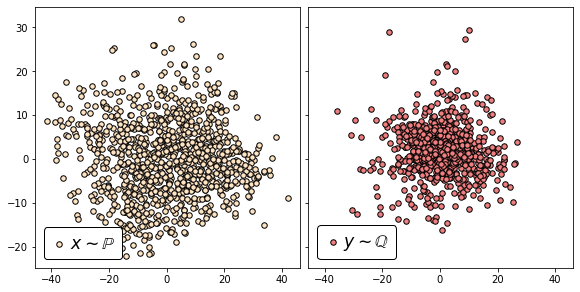

In [11]:
torch.manual_seed(153);np.random.seed(153)
fig,axes = PCA_plot_q_p_samples(benchmark,NUM_SAMPLES_PLOT_PCA,8,4,path=None,flag_p=True)

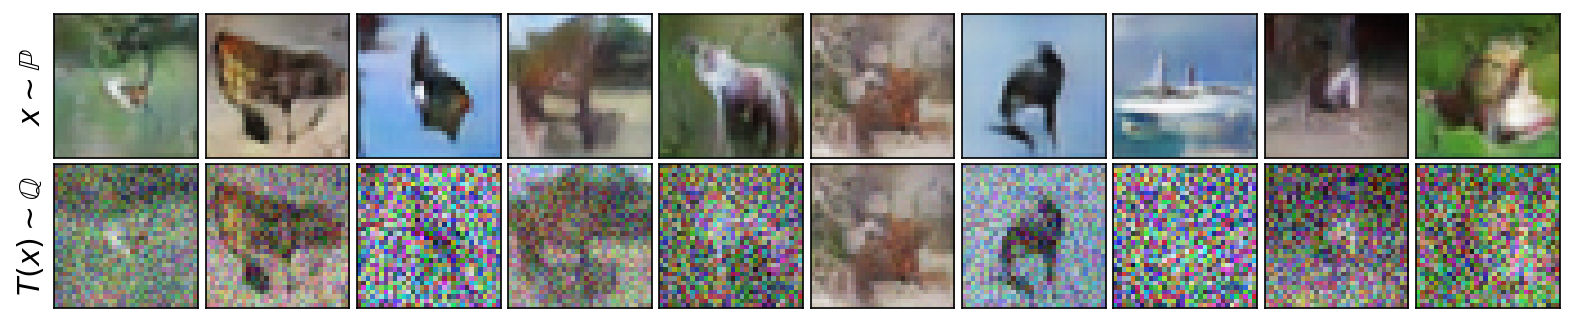

In [8]:
torch.manual_seed(8);np.random.seed(8)
fig,axes = plot_images(benchmark,10,None,shape=(3,32,32))

## 1. Take WGANs

In [12]:
torch.manual_seed(SEED_WGAN); np.random.seed(SEED_WGAN)
method = {}

In [13]:
method['wgan']    = Tiny_Discriminator(IN_CHANNELS,NDF, "wgan",flag_convolution=True ,bound=BOUND, power_iters=None)
method['wgan-gp'] = Tiny_Discriminator(IN_CHANNELS,NDF, "wgan-gp" ,flag_convolution=True)
method['wgan-lp'] = Tiny_Discriminator(IN_CHANNELS,NDF, "wgan-lp",flag_convolution=True )
method['sn-gan']  = Tiny_Discriminator(IN_CHANNELS,NDF, "sn-gan",flag_convolution=True, bound=None , power_iters=5 )

## 2. Train WGANs : WGAN, WGAN-GP and SN-GAN

100%|██████████| 5000/5000 [03:28<00:00, 24.03it/s]


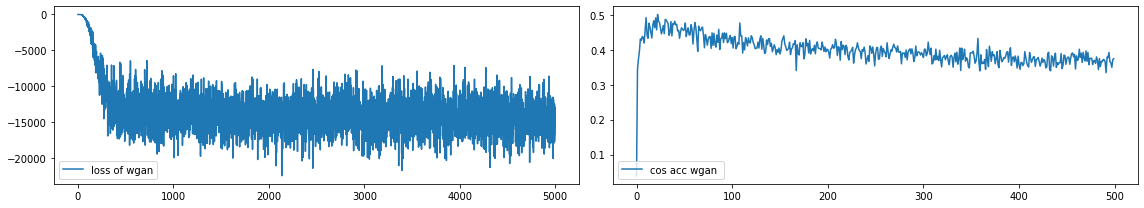

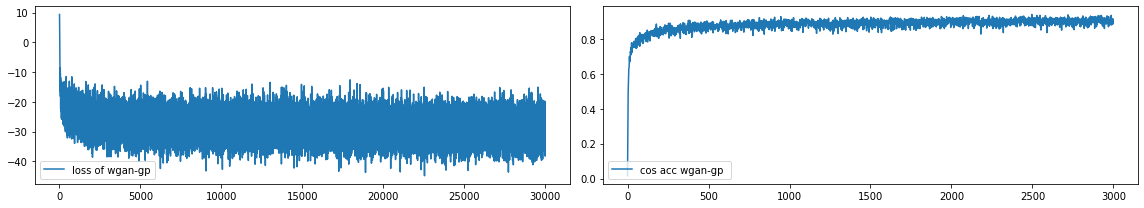

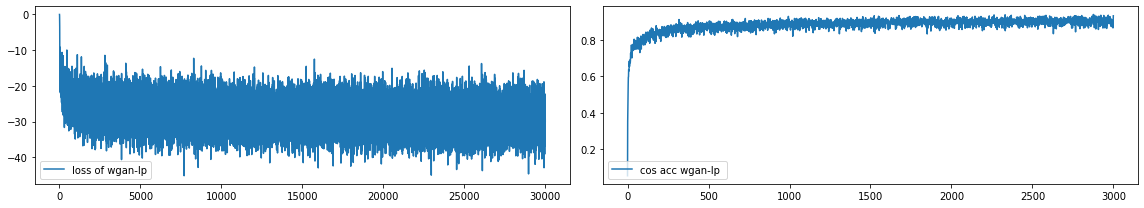

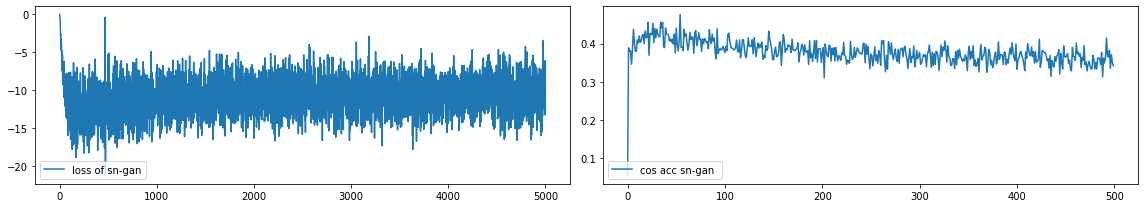

In [14]:
losses = {}
cos_accuracy = {}
times_cos = {}
critic_optimizer = {}
keys = [ 'wgan','wgan-gp','wgan-lp','sn-gan' ]
flags = [  None,'GP','LP',None ]
lmbds = {key:val for key, val in zip(keys,[0,LAMBDA_GP, LAMBDA_LP,0 ])}
num_iterations_WGAN = [ NUM_ITERATIONS_WGAN,NUM_ITERATIONS_WGAN_GP,NUM_ITERATIONS_WGAN_LP,NUM_ITERATIONS_SN_GAN  ]
num_iterations_WGAN = {key: num_it for key, num_it in zip(keys,num_iterations_WGAN)}

critic_optimizer = {key:torch.optim.Adam(method[key].parameters(),lr = LR,betas=(0, 0.9)) for key in keys}

for key,flag in zip(keys,flags):
    
    method[key] = method[key].cuda()
    
    losses[key],cos_accuracy[key], times_cos[key] = train_WGAN( 
    critic = method[key], 
    critic_optimizer = critic_optimizer[key],
    sampler_q = benchmark.output_sampler,
    sampler_p = benchmark.input_sampler,
    benchmark = benchmark,
    batch_size = BATCH_SIZE, 
    n_iterations =num_iterations_WGAN[key] ,
    flag_penalty = flag,
    lmbd = lmbds[key],
)
    # take WGAN  on CPU
    method[key] = method[key].cpu()
    del critic_optimizer[key]
    gc.collect(); torch.cuda.empty_cache()
    
    fig,ax = plt.subplots(1, 2, figsize=(16,3))
    ax[0].plot(losses[key],label = 'loss of {}'.format(key))
    ax[1].plot(cos_accuracy[key],label = 'cos acc {} '.format(key))
    ax[0].legend(loc = 'lower left')
    ax[1].legend(loc = 'lower left')
    fig.tight_layout()

### 3. CoWGAN: without Gradient Penalty

In [17]:
method['cowgan'] =   Tiny_Discriminator(IN_CHANNELS,NDF, "cowgan", flag_convolution=True)
critic_optimizer['cowgan'] = torch.optim.Adam(method['cowgan'].parameters(),lr=LR,betas=(0, 0.9))

In [18]:
method['cowgan'] = method['cowgan'].cuda()
losses_cowgan, cos_accuracy['cowgan'], times_cos['cowgan'] = train_CoWGAN(method['cowgan'], critic_optimizer['cowgan'], 
                  benchmark.output_sampler, benchmark.input_sampler,benchmark, BATCH_SIZE,
                  NUM_ITERATIONS_CoWGAN )

method['cowgan'] = method['cowgan'].cpu()
del critic_optimizer['cowgan']
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 10000/10000 [05:22<00:00, 31.01it/s]


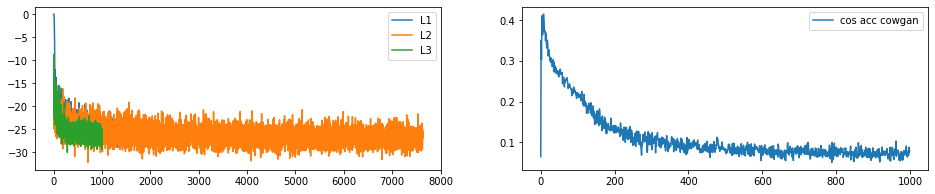

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_cowgan['L1'],label = 'L1')
ax[0].plot(losses_cowgan['L2'],label = 'L2')
ax[0].plot(losses_cowgan['L3'], label = 'L3')
ax[1].plot(cos_accuracy['cowgan'], label = 'cos acc cowgan')
ax[0].legend()
ax[1].legend();

### 4. LSOT

In [20]:
method['lsot-f'] =  Tiny_Discriminator(IN_CHANNELS,NDF, "lsot-f",flag_convolution=True)
method['lsot-g'] =  Tiny_Discriminator(IN_CHANNELS,NDF, "lsot-g", flag_convolution=True)
critic_g_optimizer = torch.optim.Adam(method['lsot-g'].parameters(),lr=LR)
critic_f_optimizer = torch.optim.Adam(method['lsot-f'].parameters(),lr=LR)

In [21]:
method['lsot-f'] = method['lsot-f'].cuda()
method['lsot-g'] = method['lsot-g'].cuda()

losses_lsot, cos_accuracy['lsot'],times_cos['lsot'] = train_LSOT(method['lsot-f'],method['lsot-g'],critic_f_optimizer,critic_g_optimizer,
                    benchmark.output_sampler,benchmark.input_sampler,benchmark,
                    BATCH_SIZE,NUM_ITERATIONS_LSOT,  
                    EPSILON_LSOT)

method['lsot-f'] = method['lsot-f'].cpu()
method['lsot-g'] = method['lsot-g'].cpu()
del critic_g_optimizer , critic_f_optimizer
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 15000/15000 [07:44<00:00, 32.29it/s]


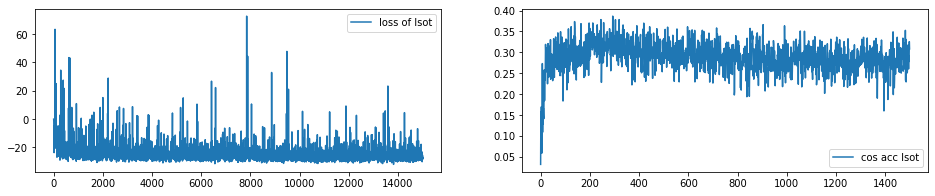

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_lsot,label = 'loss of lsot')
ax[1].plot(cos_accuracy['lsot'], label = 'cos acc lsot')
ax[0].legend()
ax[1].legend()

### 5. Train 3P-WGAN

In [26]:
mover =  Tiny_Discriminator(IN_CHANNELS,NDF, "mover",flag_convolution=False )
method['3p-wgan']  =  Tiny_Discriminator(IN_CHANNELS,NDF, "3p-wgan",flag_convolution=True, bound=None )
critic_optimizer['3p-wgan']    =  torch.optim.Adam(method['3p-wgan'].parameters(), lr=LR,betas = (0.,0.9))
optimizer_mover      =  torch.optim.Adam(mover.parameters(), lr=LR, betas = (0.,0.9))

In [27]:
method['3p-wgan'] = method['3p-wgan'].cuda()
mover = mover.cuda()

losses_3p, cos_accuracy['3p-wgan'], times_cos['3p-wgan'] = train_3PWGAN(method['3p-wgan'],
              mover,
              critic_optimizer['3p-wgan'],
              optimizer_mover,
              benchmark.output_sampler,
              benchmark.input_sampler,
              benchmark,
              BATCH_SIZE,
              NUM_ITERATIONS_3P_WGAN,
              MOVER_STEPS,
              reverse_flag=False,
             
 )


method['3p-wgan']  = method['3p-wgan'].cpu()
mover = mover.cpu()
del critic_optimizer['3p-wgan'],optimizer_mover 
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 10000/10000 [1:23:33<00:00,  1.99it/s]


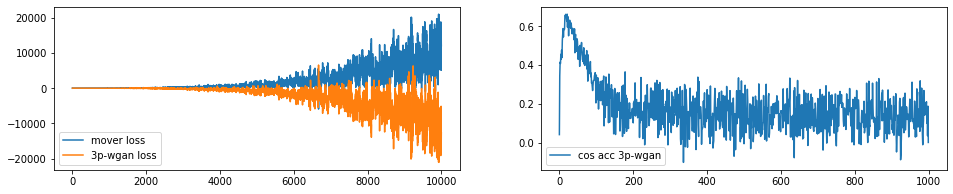

In [28]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_3p['mover'],label = 'mover loss')
ax[0].plot(losses_3p['critic'],label = '3p-wgan loss')
ax[1].plot(cos_accuracy['3p-wgan'],label = 'cos acc 3p-wgan')
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left')

## 6. 3P-WGAN Reverse

In [30]:
mover_rev =  Tiny_Discriminator(IN_CHANNELS,NDF,"3p-wgan_rev",flag_convolution=False  )
method['3p-wgan_rev'] =  Tiny_Discriminator(IN_CHANNELS,NDF, "3p-wgan_rev",flag_convolution=True  )
critic_optimizer['3p-wgan_rev']     =  torch.optim.Adam(method['3p-wgan_rev'].parameters(), lr=LR,betas = (0.,0.9))
optimizer_mover_rev     =  torch.optim.Adam(mover_rev.parameters(), lr=LR, betas = (0.,0.9))

In [31]:
mover_rev = mover_rev.cuda()
method['3p-wgan_rev'] = method['3p-wgan_rev'].cuda()

losses_3p_r,cos_accuracy['3p-wgan_rev'],times_cos['3p-wgan_rev'] = train_3PWGAN(method['3p-wgan_rev'],
              mover_rev,
            critic_optimizer['3p-wgan_rev'],
            optimizer_mover_rev,
            benchmark.output_sampler,
            benchmark.input_sampler,
            benchmark,
            BATCH_SIZE,
            NUM_ITERATIONS_MMR,
            MOVER_STEPS,
            reverse_flag=True)


method['3p-wgan_rev'] = method['3p-wgan_rev'].cpu()
mover_rev = mover_rev.cpu()
del critic_optimizer['3p-wgan_rev'] , optimizer_mover_rev 
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 5000/5000 [41:30<00:00,  2.01it/s]


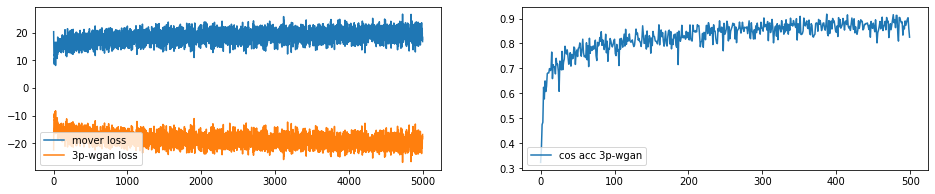

In [32]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_3p_r['mover'],label = 'mover loss')
ax[0].plot(losses_3p_r['critic'],label = '3p-wgan loss')
ax[1].plot(cos_accuracy['3p-wgan_rev'],label = 'cos acc 3p-wgan')
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left');

## 7. WGAN-qp

In [33]:
method['wgan-qp'] =  Tiny_Discriminator(IN_CHANNELS,NDF,"wgan-qp",flag_convolution=True  )
critic_optimizer['wgan-qp'] = torch.optim.Adam(method['wgan-qp'].parameters(),lr=LR)

In [34]:
method['wgan-qp'] = method['wgan-qp'].cuda()

loss_qp,cos_accuracy['wgan-qp'],times_cos['wgan-qp'] = train_WGAN_qp(method['wgan-qp'], critic_optimizer['wgan-qp'],  benchmark.output_sampler ,
                     benchmark.input_sampler,benchmark,  BATCH_SIZE,
                  NUM_ITERATIONS_WGAN_QP )

method['wgan-qp'] = method['wgan-qp'].cpu()
del critic_optimizer['wgan-qp'] 
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 10000/10000 [04:36<00:00, 36.17it/s]


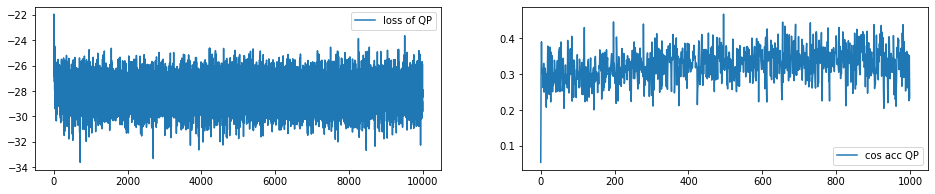

In [35]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(loss_qp,label = 'loss of QP')
ax[1].plot(cos_accuracy['wgan-qp'], label = 'cos acc QP')
ax[0].legend()
ax[1].legend();

## 8. Metrics and Results

In [36]:
# checking for 1-Lipschitz continuity
keys =  ['wgan','wgan-gp','wgan-lp','sn-gan','cowgan' ,'3p-wgan','3p-wgan_rev','lsot-f','wgan-qp']
q_samples = benchmark.output_sampler.sample(BATCH_SIZE)
for key in keys:
    method[key] = method[key].cuda()
    q_samples.requires_grad = True
    print(key,(torch.autograd.grad(method[key](q_samples),q_samples,grad_outputs = torch.ones(q_samples.shape[0],1,
                                                        device = q_samples.device))[0].norm(dim=-1) <= 1).all().item())

wgan False
wgan-gp False
wgan-lp False
sn-gan False
cowgan False
3p-wgan False
3p-wgan_rev False
lsot-f False
wgan-qp False


In [37]:
cost = {}
cost['true'] = calculate_unbiased_wasserstein(benchmark, batch_size=METRIC_SIZE) 

for key in  [ 'wgan','wgan-gp','wgan-lp','sn-gan','cowgan' ,'3p-wgan' ,'lsot-f','3p-wgan_rev','wgan-qp']:
    method[key] = method[key].cuda()
    cost[key] = calculate_kantorovitch_wasserstein( method[key] , key,
                                                       benchmark, METRIC_SIZE ) 
    method[key] = method[key].cpu()

cost['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[0] 

In [38]:
l2 = {}

for key in [ 'wgan','wgan-gp','wgan-lp','sn-gan','cowgan' ,'3p-wgan','lsot-f','wgan-qp']:
    if key in method.keys():
        method[key] = method[key].cuda()
        l2[key] = L2_metrics(method[key],None,benchmark, METRIC_SIZE,
                         flag_rev=False ) 
        method[key] = method[key].cpu()
        
mover_rev = mover_rev.cuda()
l2['3p-wgan_rev'] = L2_metrics(None,mover_rev ,benchmark, METRIC_SIZE,
                               flag_rev=True) 
mover_rev = mover_rev.cpu()

l2['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[1]  
l2['true'] = 0.

In [39]:
cos = {}
 
for key in ['wgan','wgan-gp','wgan-lp','sn-gan','lsot-f','3p-wgan'  ,'cowgan','wgan-qp']:
    if key in method.keys():
        method[key] = method[key].cuda()
        cos[key] = cosine_metrics(method[key]  ,None,benchmark, METRIC_SIZE,flag_rev=False
                              ) 
        method[key] = method[key].cpu()
 
        
mover_rev = mover_rev.cuda()
cos['3p-wgan_rev'] = cosine_metrics(None , mover_rev  ,benchmark, METRIC_SIZE,flag_rev=True
                                    ) 
mover_rev = mover_rev.cpu()

cos['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[2] 
cos['true'] = 1.0

In [40]:
results = {"cos" : cos , "l2" : l2, "cost" : cost}
results = pd.DataFrame(results)
results

,cos,l2,cost
wgan,0.371580,2.610123e+06,13880.081055
wgan-gp,0.905866,1.391334e+00,39.894196
wgan-lp,0.904201,1.391903e+00,38.237267
sn-gan,0.355060,1.674228e+00,10.799846
lsot-f,0.294073,2.169093e+00,4.890088
3p-wgan,0.131836,2.524692e+07,9648.179688
cowgan,0.071664,2.237023e+02,28.186958
wgan-qp,0.359320,1.386812e+00,4.403205
3p-wgan_rev,0.877937,2.506029e-01,20.924803
dot,0.498662,1.055589e+00,27.423471


In [43]:
path = "../metrics/metrics_cifar/width_{}/".format(WIDTH)
if not os.path.exists(path):
    os.makedirs(path)
results.to_csv(os.path.join(path,"metrics_deg_{}_seed_{}.csv".format(DEG,SEED_WGAN)))